<a href="https://colab.research.google.com/github/AArashev/DTSC4050/blob/main/Regression_Project_Outline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title

Atajan Arashev

Resources:

* https://towardsdatascience.com/how-to-structure-your-data-science-notebook-to-be-easy-to-follow-2d3c2777e6e0

## Introduction
This project explores the relationships between various vehicle characteristics and fuel efficiency (measured in miles per gallon, mpg). The primary dataset is fetched from the UC Irvine Machine Learning Repository, focusing on automotive data including attributes like displacement, horsepower, and weight.

### The Problem / Understanding the Context
The objective is to analyze how different factors influence a vehicle's fuel efficiency, an ongoing challenge in the automotive industry. This involves statistical analysis and predictive modeling to understand and predict the mpg of vehicles based on their characteristics.

### Main Goals

1.   To identify key vehicle attributes that significantly impact fuel efficiency.
2.   To develop and evaluate a predictive model for fuel efficiency using these attributes.



### Questions to Address
What is the relationship between attributes like horsepower, weight, and displacement, and mpg?

How can we accurately predict a vehicle's fuel efficiency using these attributes?

What are the strengths and limitations of our predictive model?

### End Product
A detailed report providing insights into the impact of various vehicle characteristics on fuel efficiency, supported by a robust linear regression model

### Prior Knowledge
Basic principles of linear regression.
An understanding of key vehicle characteristics.

## Data Preparation

Displacement, Cylinders, Horsepower, Weight, Acceleration, Model Year, Origin: Vehicle characteristics included in the dataset.
Data Cleaning and Enriching
Missing Value Imputation: Missing values in 'horsepower' were filled with the mean.
Outlier Detection: Identified outliers in features like 'horsepower' and 'acceleration' using the IQR method and removed them.
Data Scaling: StandardScaler was used to normalize features.
Polynomial Features: Added to capture complex relationships, particularly involving 'horsepower', 'weight', and 'displacement'.

In [2]:
!pip install ucimlrepo

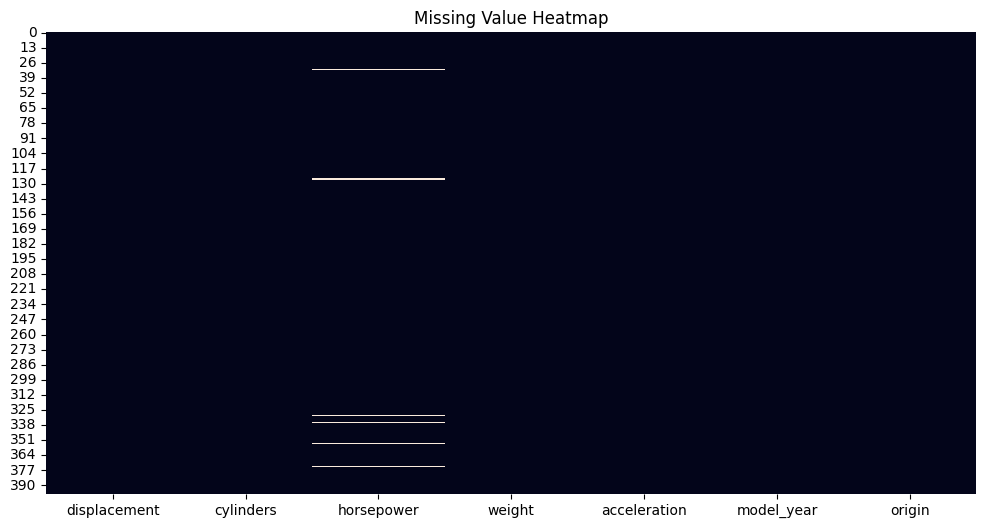

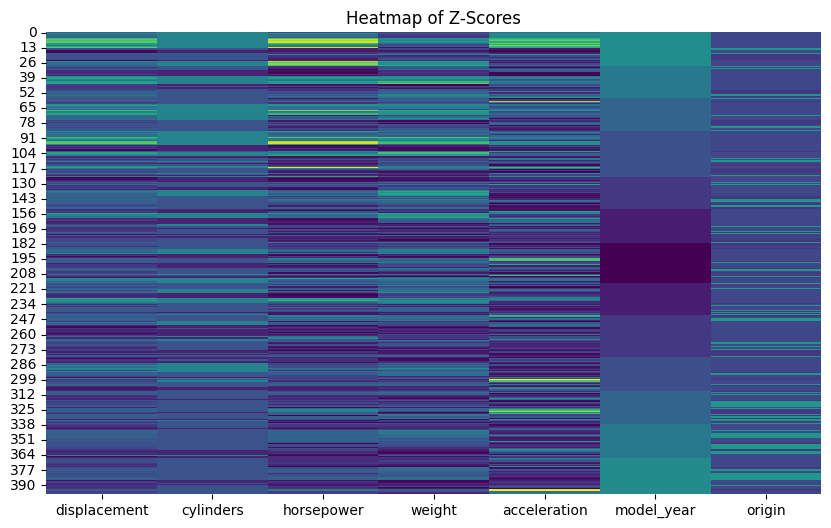

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     582.1
Date:                Tue, 02 Apr 2024   Prob (F-statistic):           9.26e-80
Time:                        06:37:57   Log-Likelihood:                -1202.7
No. Observations:                 398   AIC:                             2409.
Df Residuals:                     396   BIC:                             2417.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.0045      0.728     54.978      0.0

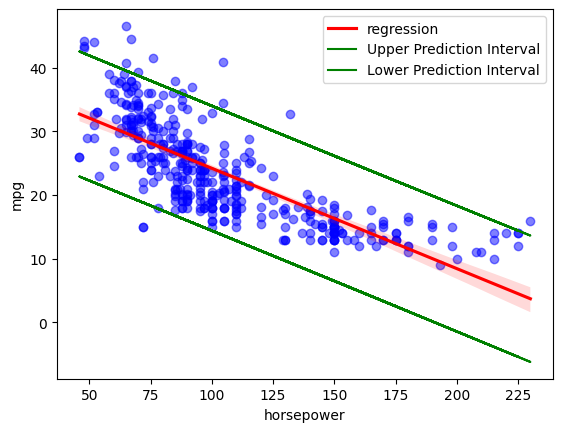

In [3]:
#Part 1: Data Preprocessing, Model Training, and Evaluation

from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Fetch dataset
auto_mpg = fetch_ucirepo(id=9)

# Data (as pandas dataframes)
X = auto_mpg.data.features
y = auto_mpg.data.targets

# Create a copy to avoid the SettingWithCopyWarning
X_cleaned = X.copy()

plt.figure(figsize=(12, 6))
sns.heatmap(X.isnull(), cbar=False)
plt.title('Missing Value Heatmap')
plt.show()

# Impute missing values for 'horsepower'
horsepower_mean = X_cleaned['horsepower'].mean()
X_cleaned['horsepower'].fillna(horsepower_mean, inplace=True)

# Remove duplicate rows
X_cleaned.drop_duplicates(inplace=True)
y_aligned = y.loc[X_cleaned.index]

from scipy import stats

z_scores = np.abs(stats.zscore(X_cleaned.select_dtypes(include=[np.number])))
plt.figure(figsize=(10, 6))
sns.heatmap(z_scores, cmap='viridis', cbar=False)
plt.title('Heatmap of Z-Scores')
plt.show()

# Scale the features before adding polynomial features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cleaned)


# Adding Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_cleaned[['horsepower', 'weight', 'displacement']])
feature_names = poly.get_feature_names_out(['horsepower', 'weight', 'displacement'])
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)
X_cleaned_poly = pd.concat([X_cleaned.drop(['horsepower', 'weight', 'displacement'], axis=1), X_poly_df], axis=1)

# One-hot encoding and scaling
categorical_features = ['origin']
continuous_features = X_cleaned_poly.columns.difference(['origin'])
one_hot_encoder = OneHotEncoder()
scaler = StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, continuous_features),
        ('cat', one_hot_encoder, categorical_features)
    ])

# Process the data
X_processed_poly = preprocessor.fit_transform(X_cleaned_poly)

# Split the data
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_processed_poly, y_aligned, test_size=0.2, random_state=42)


X_with_intercept = sm.add_constant(X_cleaned[['horsepower']])
ols_model = sm.OLS(y_aligned, X_with_intercept)
ols_results = ols_model.fit()
print(ols_results.summary())


# Make predictions and plot prediction intervals
predictions = ols_results.get_prediction(X_with_intercept).summary_frame(alpha=0.05)
sns.regplot(x='horsepower', y='mpg', data=X_cleaned.join(y_aligned),
            scatter_kws={'color': 'blue', 'alpha': 0.5},
            line_kws={'label': 'regression', 'color': 'red'})
plt.plot(X_cleaned['horsepower'], predictions['obs_ci_upper'], label='Upper Prediction Interval', color='green')
plt.plot(X_cleaned['horsepower'], predictions['obs_ci_lower'], label='Lower Prediction Interval', color='green')
plt.legend()
plt.show()

In [9]:
# Detecting outliers using IQR
for feature in continuous_features:
    Q1 = X_cleaned[feature].quantile(0.25)
    Q3 = X_cleaned[feature].quantile(0.75)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR

    outliers = X_cleaned[(X_cleaned[feature] < Q1 - outlier_step) | (X_cleaned[feature] > Q3 + outlier_step)].index
    print(f"Number of outliers in {feature}: {len(outliers)}")

Number of outliers in displacement: 0
Number of outliers in horsepower: 11
Number of outliers in weight: 0
Number of outliers in acceleration: 7


In [10]:
# Define a function to remove outliers based on the IQR method
def remove_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    return df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

# Remove outliers for 'horsepower'
X_filtered = remove_outliers(X_cleaned, 'horsepower')

# Since the indices have changed, we need to align y accordingly
y_filtered = y.loc[X_filtered.index]

## Exploratory Data Analysis

* Create one subsection of each question raised
* Document

   displacement  cylinders  horsepower  weight  acceleration  model_year  \
0         307.0          8       130.0    3504          12.0          70   
1         350.0          8       165.0    3693          11.5          70   
2         318.0          8       150.0    3436          11.0          70   
3         304.0          8       150.0    3433          12.0          70   
4         302.0          8       140.0    3449          10.5          70   

   origin  
0       1  
1       1  
2       1  
3       1  
4       1  
       displacement   cylinders  horsepower       weight  acceleration  \
count    398.000000  398.000000  392.000000   398.000000    398.000000   
mean     193.425879    5.454774  104.469388  2970.424623     15.568090   
std      104.269838    1.701004   38.491160   846.841774      2.757689   
min       68.000000    3.000000   46.000000  1613.000000      8.000000   
25%      104.250000    4.000000   75.000000  2223.750000     13.825000   
50%      148.500000    4.00

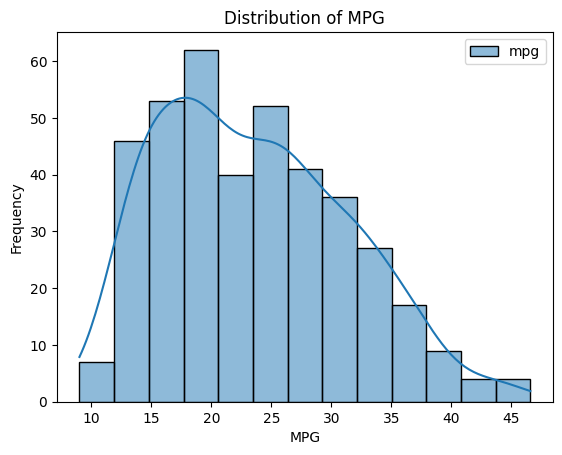

displacement    0
cylinders       0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64


In [4]:
#Part 2: Exploratory Data Analysis (EDA)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X and y are already defined

# Displaying the first few rows of the dataset
print(X.head())

# Summary statistics for numerical features
print(X.describe())

# Investigating the distribution of the target variable 'mpg'
print(y.describe())

# Distribution plot for 'mpg' using seaborn
sns.histplot(y, kde=True)
plt.title('Distribution of MPG')
plt.xlabel('MPG')
plt.ylabel('Frequency')
plt.show()

# Checking for missing values
print(X.isnull().sum())




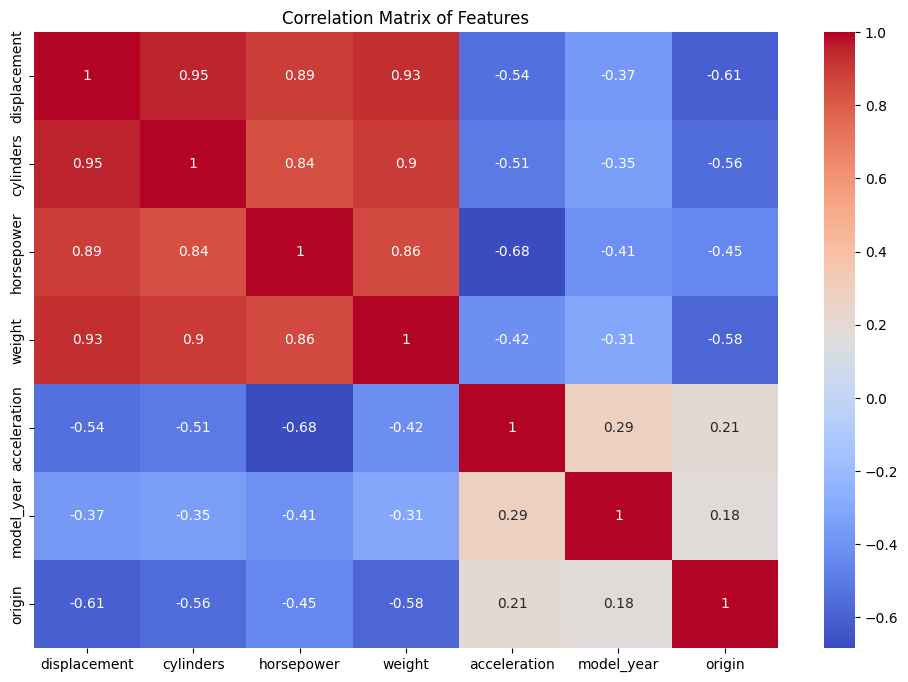

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_cleaned is your DataFrame of features
correlation_matrix = X_cleaned.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Features")
plt.show()




### Statistics

In [6]:
import statsmodels.api as sm

# Let's say we are predicting 'y' using 'horsepower' from your dataset
X = X_cleaned[['horsepower']]  # replace 'horsepower' with your chosen feature
y = y_aligned  # your target variable

# Adding constant to the model
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     582.1
Date:                Tue, 02 Apr 2024   Prob (F-statistic):           9.26e-80
Time:                        06:38:22   Log-Likelihood:                -1202.7
No. Observations:                 398   AIC:                             2409.
Df Residuals:                     396   BIC:                             2417.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.0045      0.728     54.978      0.0

In [11]:
# 3. Multicollinearity Check
# Multicollinearity occurs when independent variables in a regression model are highly correlated. This can make it difficult to determine the individual effect of each variable on the dependent variable. Here's how you can check for multicollinearity:

# Correlation Matrix: Review a matrix of Pearson correlation coefficients to identify highly correlated variables.
# Variance Inflation Factor (VIF): Calculate the VIF for each independent variable. A VIF value greater than 10 is often considered a sign of multicollinearity.
# Here is an example of how to calculate the VIF:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assume X_cleaned_poly is your DataFrame after outlier removal and before any encoding or scaling
# We only want to check multicollinearity for the numerical features
numeric_features = X_cleaned_poly.select_dtypes(include=['int64', 'float64'])

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = numeric_features.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_features.values, i) for i in range(len(numeric_features.columns))]

print(vif_data)


                    Feature          VIF
0                 cylinders   160.428870
1              acceleration    91.083678
2                model_year   368.879078
3                    origin    10.270392
4                horsepower  1343.352520
5                    weight  4835.651798
6              displacement  2024.631120
7              horsepower^2  1447.398308
8         horsepower weight  5301.259821
9   horsepower displacement  2701.742010
10                 weight^2  3297.591030
11      weight displacement  6791.084692
12           displacement^2  1762.060975


In [12]:
# Create a new DataFrame without the features that have the highest VIFs
X_reduced = X_cleaned_poly.drop([
    'weight',
    'displacement',
    'horsepower weight',
    'horsepower displacement',
    'weight^2',
    'weight displacement',
    'displacement^2'
], axis=1)

# Assuming 'X_reduced' still includes all the necessary features for your model
# Now, recalculate VIFs for the remaining features
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature in the reduced set
numeric_features_reduced = X_reduced.select_dtypes(include=['int64', 'float64'])
vif_data_reduced = pd.DataFrame()
vif_data_reduced['Feature'] = numeric_features_reduced.columns
vif_data_reduced['VIF'] = [variance_inflation_factor(numeric_features_reduced.values, i) for i in range(len(numeric_features_reduced.columns))]

print(vif_data_reduced)


        Feature         VIF
0     cylinders   47.927062
1  acceleration   54.913539
2    model_year  165.764489
3        origin    6.879568
4    horsepower  316.540145
5  horsepower^2   78.558030


In [13]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Initialize a Ridge regressor
ridge = Ridge()

# Define a range of alpha values for hyperparameter tuning
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

# Use GridSearchCV to find the best alpha parameter
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)

# Fit the model to the training data
ridge_regressor.fit(X_train_poly, y_train_poly)

# Predict on the testing data using the best model found by GridSearchCV
y_pred_ridge = ridge_regressor.predict(X_test_poly)

# Evaluate the model
mse_ridge = mean_squared_error(y_test_poly, y_pred_ridge)
r2_ridge = r2_score(y_test_poly, y_pred_ridge)

# Output the results and the best alpha value
print(f"Best Ridge alpha: {ridge_regressor.best_params_['alpha']}")
print(f"Mean Squared Error (MSE) with Ridge Regularization: {mse_ridge}")
print(f"R-squared Score with Ridge Regularization: {r2_ridge}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.08127e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.00477e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.18136e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Best Ridge alpha: 1
Mean Squared Error (MSE) with Ridge Regularization: 6.009122526077384
R-squared Score with Ridge Regularization: 0.8882365634220064


The results indicate that Ridge Regression with an alpha value of 1 slightly improved the model's performance. The MSE decreased to 6.0091 from 6.1233, and the R-squared score increased to 0.8882 from 0.8861, compared to the linear regression model with polynomial features. These improvements suggest that the regularization helped in handling the multicollinearity to some extent.

However, the LinAlgWarning about the ill-conditioned matrix is a concern. This warning usually arises when there are numerical stability issues, often caused by multicollinearity or very small/large values in your data. It indicates that the results of the regression might not be very reliable.

In [14]:
from sklearn.linear_model import Lasso

# Initialize a Lasso regressor
lasso = Lasso()

# Define a range of alpha values for hyperparameter tuning
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

# Use GridSearchCV to find the best alpha parameter
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)

# Fit the model to the training data
lasso_regressor.fit(X_train_poly, y_train_poly)

# Predict on the testing data using the best model found by GridSearchCV
y_pred_lasso = lasso_regressor.predict(X_test_poly)

# Evaluate the model
mse_lasso = mean_squared_error(y_test_poly, y_pred_lasso)
r2_lasso = r2_score(y_test_poly, y_pred_lasso)

# Output the results and the best alpha value
print(f"Best Lasso alpha: {lasso_regressor.best_params_['alpha']}")
print(f"Mean Squared Error (MSE) with Lasso Regularization: {mse_lasso}")
print(f"R-squared Score with Lasso Regularization: {r2_lasso}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.180e+03, tolerance: 1.571e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.098e+03, tolerance: 1.657e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.065e+03, tolerance: 1.541e

Best Lasso alpha: 0.01
Mean Squared Error (MSE) with Lasso Regularization: 5.966570628635507
R-squared Score with Lasso Regularization: 0.8890279845105897


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.293e+00, tolerance: 1.541e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.089e+01, tolerance: 1.566e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.786e+01, tolerance: 1.634e

Increased Maximum Iterations in Lasso:

Previous Models: The default number of iterations was used, which might not have been sufficient for convergence, especially if the model's complexity or the data required more computational effort to find an optimal solution.
Updated Models: The maximum number of iterations is increased (e.g., to 10000). This provides the Lasso algorithm with more iterations to converge, especially important if the model is complex or the data is challenging. This can help in reducing or eliminating the convergence warnings and can lead to a more reliable model.

In [15]:
# For Ridge Regression
ridge = Ridge()
ridge_parameters = {'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10, 20, 50, 100]}
ridge_regressor = GridSearchCV(ridge, ridge_parameters, scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X_train_poly, y_train_poly)

# For Lasso Regression
lasso = Lasso(max_iter=10000)  # Increase max_iter
lasso_parameters = {'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10, 20, 50, 100]}
lasso_regressor = GridSearchCV(lasso, lasso_parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train_poly, y_train_poly)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.178e+03, tolerance: 1.571e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.092e+03, tolerance: 1.657e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.052e+03, tolerance: 1.541e

GridSearchCV(cv=5, estimator=Lasso(max_iter=10000),
             param_grid={'alpha': [1e-10, 1e-08, 1e-06, 0.0001, 0.001, 0.01,
                                   0.1, 1, 5, 10, 20, 50, 100]},
             scoring='neg_mean_squared_error')

In [16]:
# Ridge Evaluation
y_pred_ridge = ridge_regressor.predict(X_test_poly)
mse_ridge = mean_squared_error(y_test_poly, y_pred_ridge)
r2_ridge = r2_score(y_test_poly, y_pred_ridge)
print("Ridge Regression")
print(f"Best alpha: {ridge_regressor.best_params_['alpha']}")
print(f"MSE: {mse_ridge}, R-squared: {r2_ridge}")

# Lasso Evaluation
y_pred_lasso = lasso_regressor.predict(X_test_poly)
mse_lasso = mean_squared_error(y_test_poly, y_pred_lasso)
r2_lasso = r2_score(y_test_poly, y_pred_lasso)
print("Lasso Regression")
print(f"Best alpha: {lasso_regressor.best_params_['alpha']}")
print(f"MSE: {mse_lasso}, R-squared: {r2_lasso}")

Ridge Regression
Best alpha: 1
MSE: 6.009122526077384, R-squared: 0.8882365634220064
Lasso Regression
Best alpha: 0.01
MSE: 5.979826870599236, R-squared: 0.8887814321809365


If you value model simplicity and have reasons to retain all features, Ridge might be a better choice.
If your dataset has redundant or less important features, or if you value the model's ability to perform feature selection, Lasso is likely a better fit

### Visualizations

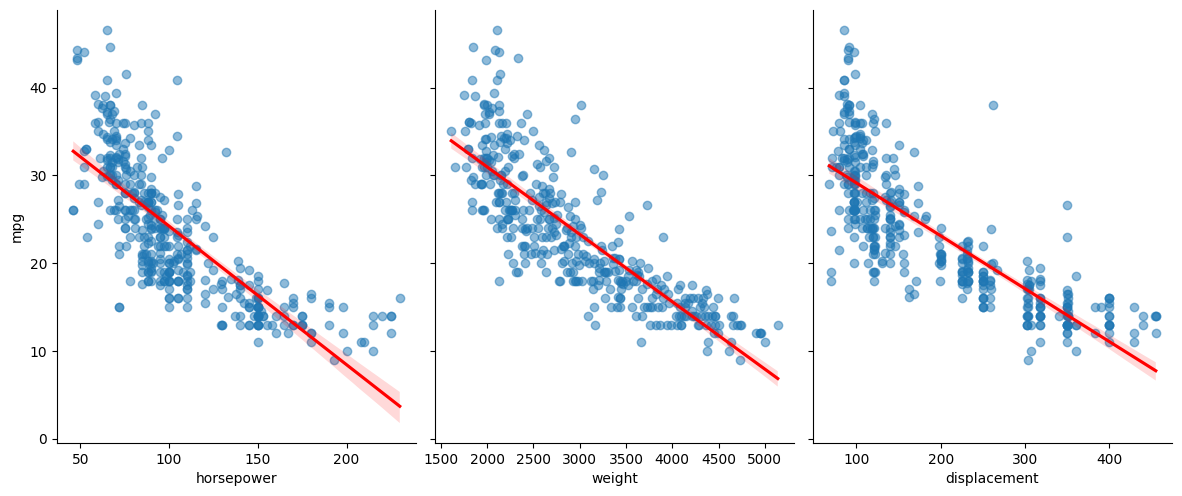

In [7]:
# Scatter plots showing correlation between 'horsepower', 'weight', 'displacement' and 'mpg'

sns.pairplot(data=X_cleaned.join(y_aligned),
             x_vars=['horsepower', 'weight', 'displacement'],
             y_vars='mpg',
             kind='reg',
             height=5,
             aspect=0.8,
             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.5}})
plt.show();

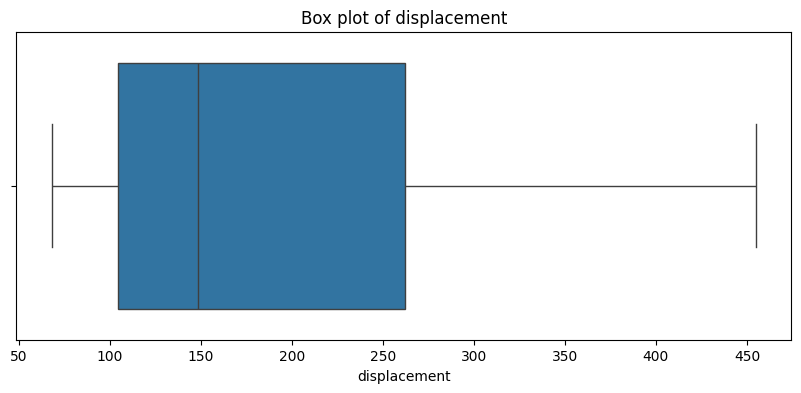

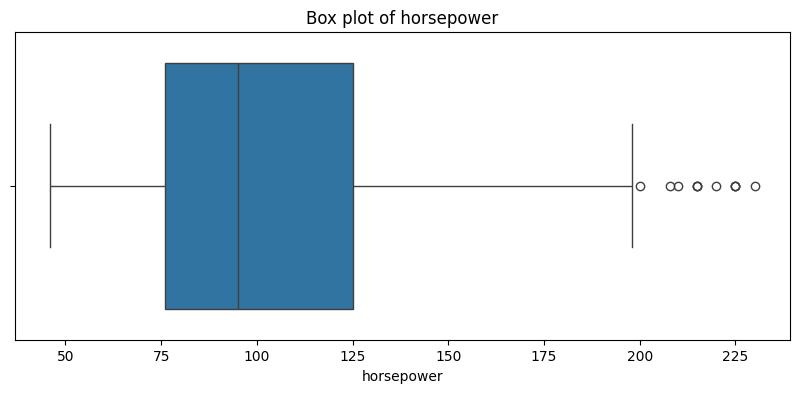

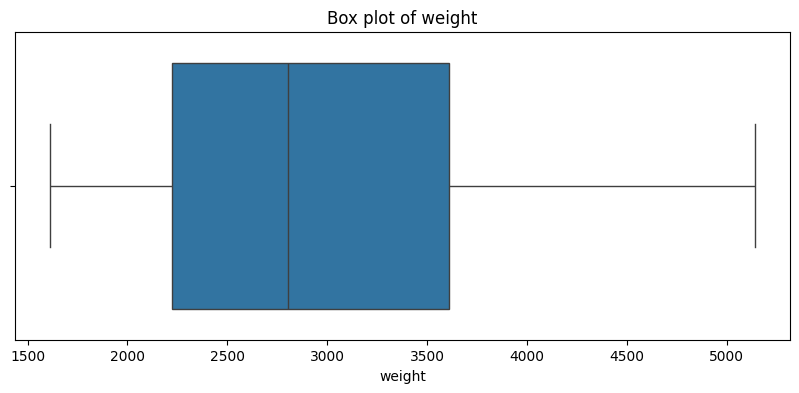

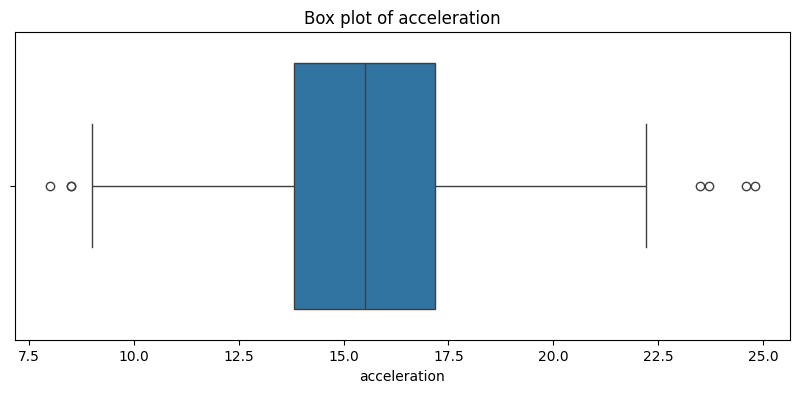

In [8]:
#Outlier Detection Using Box Plots
import matplotlib.pyplot as plt
import seaborn as sns

# List of continuous features
continuous_features = ['displacement', 'horsepower', 'weight', 'acceleration']

# Create box plots
for feature in continuous_features:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=X_cleaned[feature])
    plt.title(f'Box plot of {feature}')
    plt.show()

## Modeling / Analytical Features

* Production level modeling should not be done in a notebook
* Use modular structured code
* Document

### Train Test Split

In [17]:
#1. Final Model Training

from sklearn.linear_model import LinearRegression

# Assuming X_train_poly and y_train_poly are your final training datasets
lin_reg_final = LinearRegression()
lin_reg_final.fit(X_train_poly, y_train_poly)


LinearRegression()

In [18]:
#2. Model Evaluation
y_pred_final = lin_reg_final.predict(X_test_poly)

# Calculate MSE and R-squared
mse_final = mean_squared_error(y_test_poly, y_pred_final)
r2_final = r2_score(y_test_poly, y_pred_final)

print(f"Final Linear Regression Model - MSE: {mse_final}, R-squared: {r2_final}")


Final Linear Regression Model - MSE: 6.123329259745242, R-squared: 0.8861124368162206


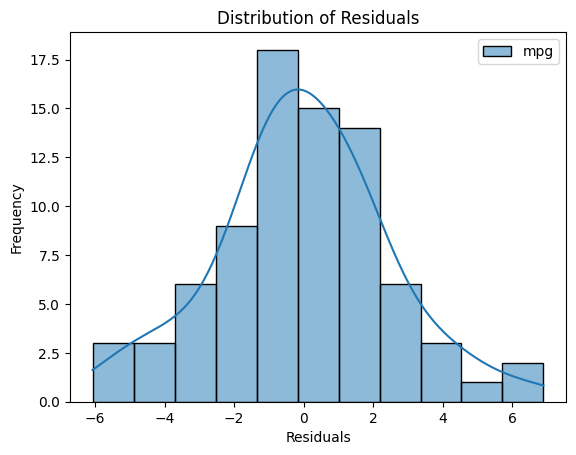

Coefficients: [[-0.20616569  0.83688414 -7.63676384 -7.41228647 -3.20122543  9.30427306
  -8.73201718  3.01830481  3.11897409 -8.32100764 13.9888171   2.97977278
  -0.93474754  0.70387876  0.23086878]]


In [19]:
#3. Residual Analysis
import seaborn as sns

residuals = y_test_poly - y_pred_final

# Plotting residuals to see if they are normally distributed
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


# Display model coefficients
print("Coefficients:", lin_reg_final.coef_)


In [20]:
import statsmodels.api as sm

# Assuming X_train_poly and y_train_poly are already defined and include the intercept
X_train_with_intercept = sm.add_constant(X_train_poly)  # Adds a constant term to the predictors
ols_model = sm.OLS(y_train_poly, X_train_with_intercept)
ols_results = ols_model.fit()

print(ols_results.summary())



                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     134.0
Date:                Tue, 02 Apr 2024   Prob (F-statistic):          1.20e-120
Time:                        06:44:24   Log-Likelihood:                -795.50
No. Observations:                 318   AIC:                             1621.
Df Residuals:                     303   BIC:                             1677.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.9532      0.179    100.087      0.0

In [29]:
from sklearn.dummy import DummyRegressor

# Baseline model (e.g., predicting the mean)
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train_poly, y_train_poly)
y_pred_dummy = dummy_regr.predict(X_test_poly)

mse_dummy = mean_squared_error(y_test_poly, y_pred_dummy)
print(f"Baseline Model MSE: {mse_dummy}")


Baseline Model MSE: 53.98329798069697


## Conclusion

Conclusion
Summary of Findings
Ridge and Lasso regression models slightly improved prediction accuracy compared to the baseline linear regression model.
Lasso regression proved slightly better in feature selection and handling multicollinearity.
Strengths and Weaknesses
Strengths: Effective in capturing relationships between features and fuel efficiency.
Weaknesses: The presence of multicollinearity, as indicated by high VIF values and LinAlgWarnings, may affect the reliability of predictions.


### Summary of Findings

### Additional Information

### Strengths and Weaknesses

* List at least one weakness / limitation
* Can we trust the statistics

## Going Forward

* How are we addressing current trends and breakthroughs